### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from collections import defaultdict
import imaplib
import email
from email.header import decode_header
import os
from dotenv import load_dotenv
from pdf2image import convert_from_bytes
import pytesseract
import re
import cv2
import numpy as np
from bs4 import BeautifulSoup
from imbox import Imbox
import imaplib
import io
from PIL import Image
import matplotlib.pyplot as plt
from parsers.maxima_parser import maxima_parser

from pdf2image import convert_from_bytes

imaplib.IMAP4._encoding = 'utf-8'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

### Initialize connection

In [3]:
# Initialize connection
load_dotenv()
imap_server = os.getenv("IMAP_SERVER")
email_address = os.getenv("EMAIL_ADDRESS")
password = os.getenv("EMAIL_PASSWORD")

mail = Imbox(imap_server, username=email_address, password=password, ssl=True, ssl_context=None, starttls=False)

In [4]:
filters = [
    {"sender": "noreply.tsekk@maxima.ee", "subject": "Sinu ostutšekk!"},
    {"sender": "noreply@rimibaltic.com", "subject": "Sinu ostutšekk"},
    {"sender": "estonia-food@bolt.eu", "subject": "Delivery from Bolt Food"}
]

### Parse Maxima

In [5]:
filter_criteria = filters[0] # maximaa

filter_sender = filter_criteria["sender"]
filter_subject = filter_criteria["subject"]

messages = mail.messages(sent_from=filter_sender)

In [13]:
parsed_receipts = []

for uid, message in messages:
    if message.subject == filter_subject:
        sent_from = message.sent_from
        sent_to = message.sent_to
        subject = message.subject
        headers = message.headers
        message_id = message.message_id
        date = message.date
        body = message.body
        attachments = message.attachments

        results = maxima_parser(body['html'][0])
        parsed_receipts.append(results)

Total Spent: 183.68 €
Total Discounts: nan €
Most Frequently Purchased Product: Kohuke MAGIJA
Total Spending Per Day:
dtime
2024-05-27     9.73
2024-05-30    18.88
2024-06-01     5.28
2024-06-02    17.73
2024-06-03    19.38
2024-06-05    21.12
2024-06-07    16.89
2024-06-09    27.54
2024-06-10     7.57
2024-06-11     8.22
2024-06-12    13.95
2024-06-19    15.62
2024-06-20    15.58
2024-06-21    16.55
2024-06-26    12.69
2024-06-29    11.42
Name: price, dtype: float64
Total Spending Per Month:
dtime
2024-05     28.61
2024-06    209.54
Freq: M, Name: price, dtype: float64
Total Spending Per Store:
Võru 55, Tartu        122.33
Turu tn. 14, Tartu     61.35
dtype: float64
Average Spending Per Store: 91.84 €


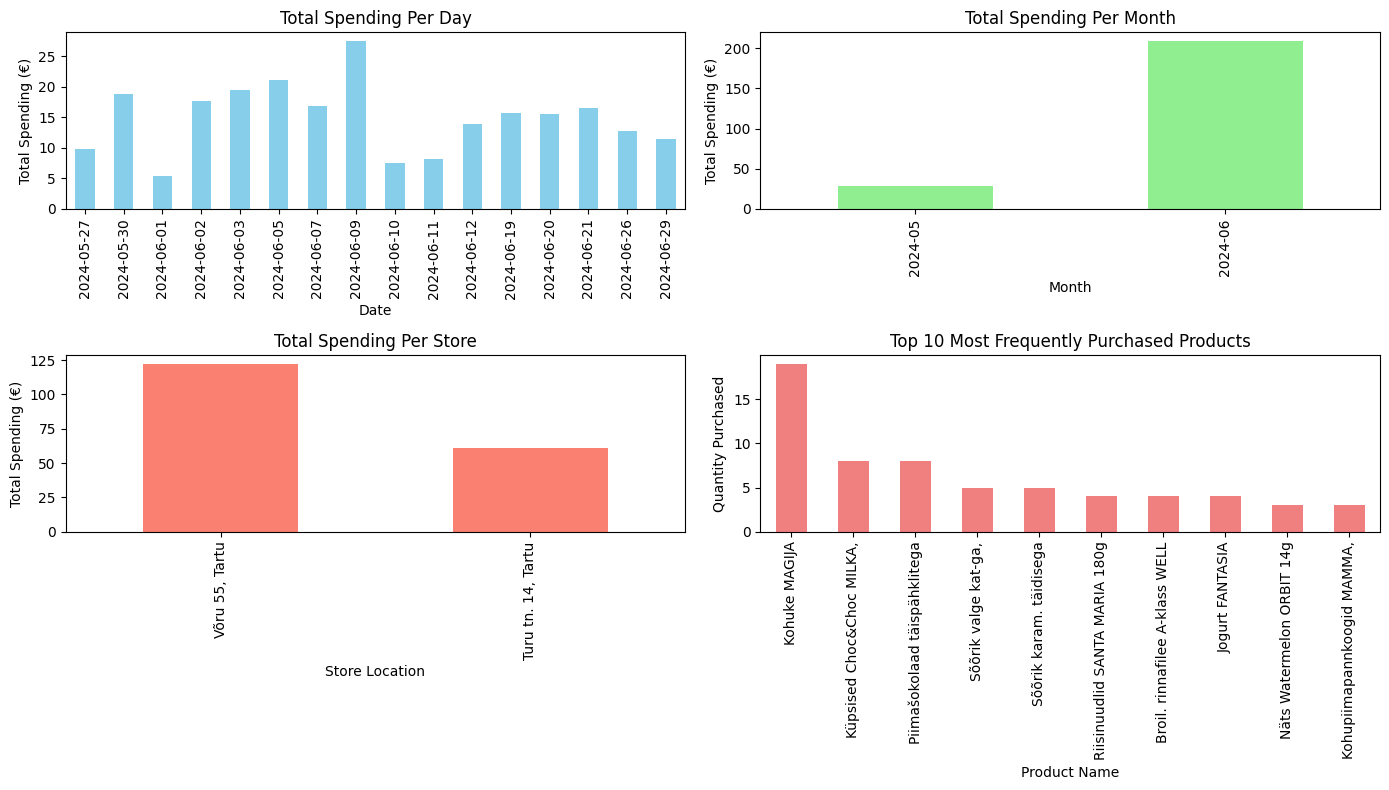

(           location               dtime                    product_name  \
 0    Võru 55, Tartu 2024-05-27 21:58:02       Küpsised Choc&Choc MILKA,   
 1    Võru 55, Tartu 2024-05-27 21:58:02    Piimašokolaad täispähklitega   
 2    Võru 55, Tartu 2024-05-27 21:58:02    Suur kilekott MAXIMA 38x64cm   
 3    Võru 55, Tartu 2024-05-30 11:01:00  Broil. rinnafilee A-klass WELL   
 4    Võru 55, Tartu 2024-05-30 11:01:00                   Kohuke MAGIJA   
 ..              ...                 ...                             ...   
 122  Võru 55, Tartu 2024-06-29 14:59:32      Küpsised Choco Minis MILKA   
 123  Võru 55, Tartu 2024-06-29 14:59:32       Broil. rinnafilee palad A   
 124  Võru 55, Tartu 2024-06-29 14:59:32              Sõõrik valge kat.,   
 125  Võru 55, Tartu 2024-06-29 14:59:32                 Jogurt FANTASIA   
 126  Võru 55, Tartu 2024-06-29 14:59:32    Kompvekikarp Toffifee STORCK   
 
      quantity  price  discount  
 0         2.0   5.50      2.32  
 1         2.0   3

In [19]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

def analyze_spending(data):
    # Initialize lists and variables to collect all data
    all_purchases = []
    total_spent_per_store = defaultdict(float)
    product_frequency = defaultdict(int)
    total_discounts = 0
    total_spent = 0

    for entry in data:
        location = entry['location']
        total_spent_per_store[location] += entry['total']
        total_spent += entry['total']

        # Parse the date and time
        dtime = datetime.strptime(entry['dtime'], "%d.%m.%Y %H:%M:%S")

        # Process the DataFrame of products directly
        products_df = entry['products']
        
        # Aggregate product data
        for _, product in products_df.iterrows():
            product_name = product['name_products']
            quantity = product['quantity']
            price = product['price']
            discount = product['discount']
            
            # Update product frequency and total discounts
            product_frequency[product_name] += quantity
            total_discounts += discount
            
            # Collect all purchase data
            all_purchases.append({
                'location': location,
                'dtime': dtime,
                'product_name': product_name,
                'quantity': quantity,
                'price': price,
                'discount': discount
            })

    df = pd.DataFrame(all_purchases)

    # Calculate stats
    most_frequent_product = df.groupby('product_name')[['quantity', 'price', 'discount']].sum().sort_values(by='quantity', ascending=False).head(1)
    total_per_day = df.groupby(df['dtime'].dt.date)['price'].sum()
    total_per_month = df.groupby(df['dtime'].dt.to_period('M'))['price'].sum()
    total_per_store = pd.Series(total_spent_per_store).sort_values(ascending=False)
    
    avg_spent_per_store = total_per_store.mean()

    # Stats
    print(f"Total Spent: {total_spent:.2f} €")
    print(f"Total Discounts: {total_discounts:.2f} €")
    print(f"Most Frequently Purchased Product: {most_frequent_product.index[0]}")
    print(f"Total Spending Per Day:\n{total_per_day}")
    print(f"Total Spending Per Month:\n{total_per_month}")
    print(f"Total Spending Per Store:\n{total_per_store}")
    print(f"Average Spending Per Store: {avg_spent_per_store:.2f} €")

    plt.figure(figsize=(14, 8))

    # Plot 1: Total Spending Per Day
    plt.subplot(2, 2, 1)
    total_per_day.plot(kind='bar', color='skyblue')
    plt.title('Total Spending Per Day')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Date')

    # Plot 2: Total Spending Per Month
    plt.subplot(2, 2, 2)
    total_per_month.plot(kind='bar', color='lightgreen')
    plt.title('Total Spending Per Month')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Month')

    # Plot 3: Total Spending Per Store
    plt.subplot(2, 2, 3)
    total_per_store.plot(kind='bar', color='salmon')
    plt.title('Total Spending Per Store')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Store Location')

    # Plot 4: Most Frequently Purchased Products
    top_products = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
    plt.subplot(2, 2, 4)
    top_products.plot(kind='bar', color='lightcoral')
    plt.title('Top 10 Most Frequently Purchased Products')
    plt.ylabel('Quantity Purchased')
    plt.xlabel('Product Name')

    plt.tight_layout()
    plt.show()

    return df, total_spent_per_store, product_frequency

analyze_spending(parsed_receipts)


### Parse RIMI

In [5]:
filter_criteria = filters[1] # rimi

filter_sender = filter_criteria["sender"]
filter_subject = filter_criteria["subject"]

messages = mail.messages(sent_from=filter_sender)

In [6]:
parsed_receipts = []

for uid, message in messages:
    if message.subject == filter_subject:
        sent_from = message.sent_from
        sent_to = message.sent_to
        subject = message.subject
        headers = message.headers
        message_id = message.message_id
        date = message.date
        body = message.body
        attachments = message.attachments

        break

In [7]:
pdf_io = [a for a in attachments if a['content-type'] == 'application/pdf'][0]['content']
pdf_io.getvalue()


# use ocr
images = convert_from_bytes(pdf_io.getvalue(), poppler_path=r'C:/Program Files/poppler-24.07.0/Library/bin')

# detect different sections and parse them separately

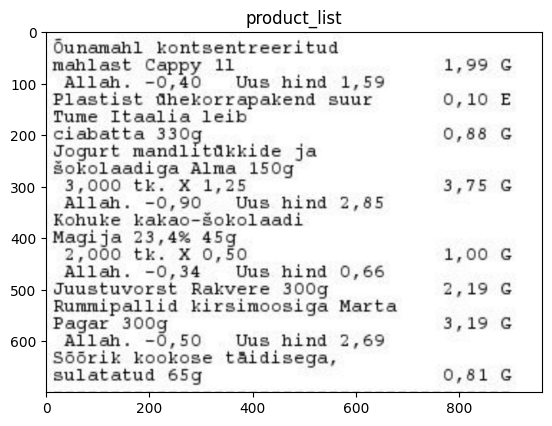

In [74]:
def parse_store_info(text):
    # Find the address lines by splitting the text and looking for patterns
    lines = text.splitlines()
    address_lines = []
    store_info_start = False
    
    for line in lines:
        if "KMKNR" in line:
            store_info_start = True
            continue
        if store_info_start:
            if "www" in line:
                break
            if line.strip():
                address_lines.append(line.strip())
    
    return ', '.join(address_lines)

def parse_total_info(text):
    datetime_match = re.search(r'KUUPAEV:\s*(\d{2}\.\d{2}\.\d{4})\s+AEG:\s*(\d{2}:\d{2}:\d{2})', text)
    if datetime_match:
        date = datetime_match.group(1)
        time = datetime_match.group(2)
        return f"{date} {time}"
    return None

def parse_product_list(text):
    # Split text into lines
    lines = text.splitlines()

    products = []
    current_product = {}
    price_pattern = re.compile(r'\d+,\d{2}\s\w')  # Pattern to match prices like 3,19 G

    for line in lines:
        line = line.strip()

        # Check if line is a price
        if price_pattern.search(line):
            current_product['price'] = price_pattern.search(line).group()
            products.append(current_product)
            current_product = {}
        elif line.startswith('Allah.'):
            # It's a discount line, skip or store as needed
            current_product['discount'] = line
        else:
            # It's part of the product description
            if 'name' not in current_product:
                current_product['name'] = line
            else:
                current_product['name'] += ' ' + line

    # products = [p for p in products if 'name' in p.keys()]
    return products


img = np.array(images[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 1)) # horizontal line
morph = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

imgLines= cv2.HoughLinesP(morph, 10, np.pi/180, 20, minLineLength = 440, maxLineGap = 15)

if len(imgLines) == 0:
    print('No dashed lines detected')

lines = [int((line[0][1]+line[0][3])/2) for line in imgLines]
lines = sorted(lines)

roi_list = {
    'store_info': (0,lines[0]),
    'product_list': (lines[1],lines[2]),
    'total_info': (lines[5],img.shape[0])
}

# Apply OCR to each region of interest
results = {}
for section_name, (start_y, end_y) in roi_list.items():
    roi = img[start_y:end_y, :]
    text = pytesseract.image_to_string(roi)

    if section_name == 'store_info':
        results['location'] = parse_store_info(text)
    if section_name == 'product_list':
        results['products'] = parse_product_list(text)

        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(section_name)
        plt.show()
        break

    if section_name == 'total_info':
        results['dtime'] = parse_total_info(text)
    
    


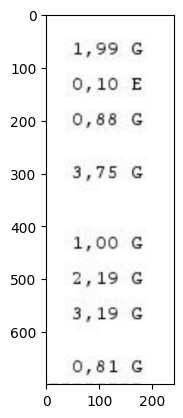

In [76]:
plt.imshow(roi[:,int(roi.shape[1]*0.75):roi.shape[1]])

In [64]:
len(results['products'])

10

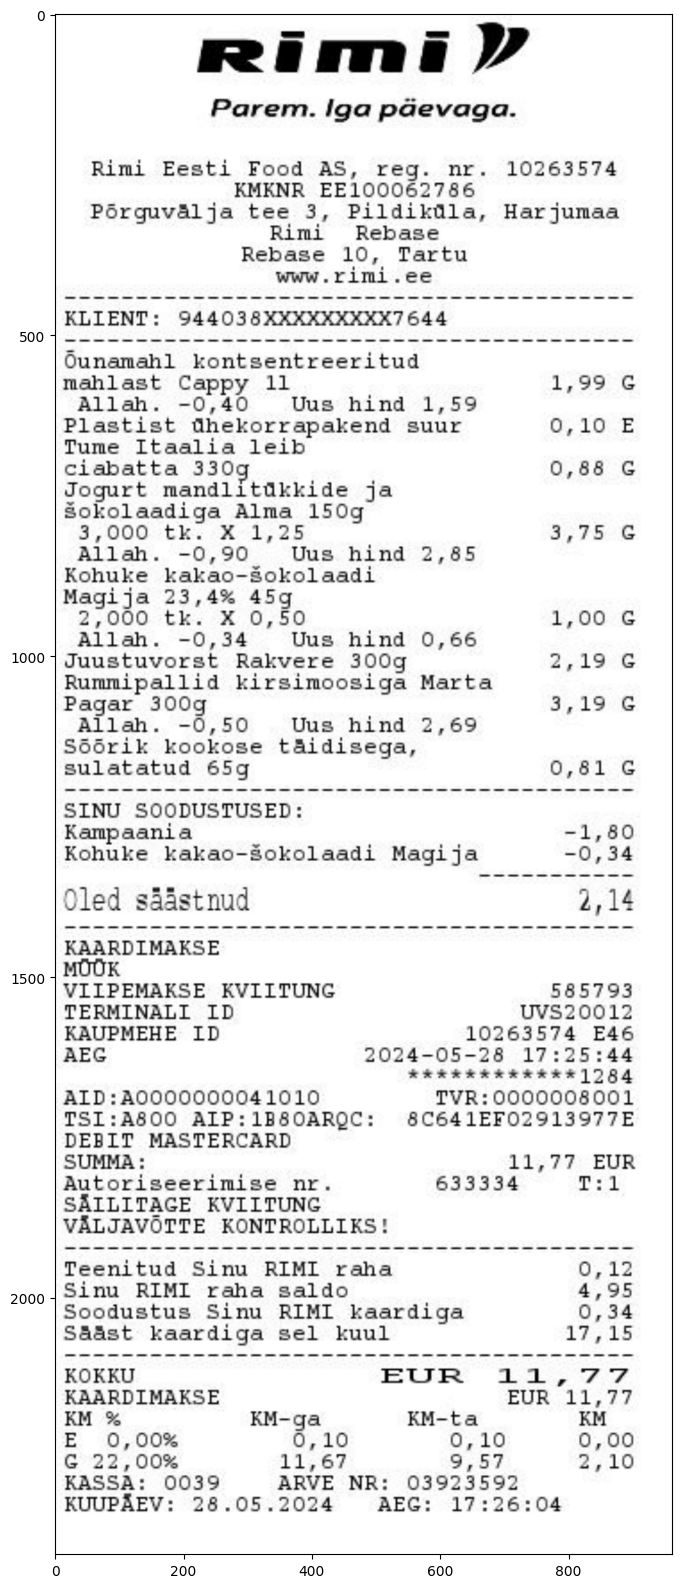

In [58]:
plt.figure(figsize=(20,20))
plt.imshow(img)

In [45]:
product_img = img[lines[1]:lines[2],:]